# Gathering Data from Spotify Charts and Using the Spotify API

Using data collected from Spotify Charts and the Spotify Web API, we can explore some attributes of popular songs streamed on Spotify. 

First, I import the necessary libraries/modules. For instance, `spotipy` is used to access data from the Spotify Web API, `pandas` allows us to perform data wrangling and analysis, and the `os` module helps us manage files, directories, and environment variables.

In [1]:
# Import libraries
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import pandas as pd
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np


I load environment variables that permit access to the Spotify API using `load_dotenv()` so that I can call the Spotify API as an authorized user. Accessing the Spotify Web API involves creating an "app" at [developer.spotify.com](https://developer.spotify.com/dashboard).

In [2]:
# Initialize the Spotify API client, use client id from command terminal 
load_dotenv()

# Access the variables
SPOTIPY_CLIENT_ID = os.getenv('SPOTIPY_CLIENT_ID')
SPOTIPY_CLIENT_SECRET = os.getenv('SPOTIPY_CLIENT_SECRET')
SPOTIPY_REDIRECT_URI = os.getenv('SPOTIPY_REDIRECT_URI')

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials
                    (client_id=SPOTIPY_CLIENT_ID,
                    client_secret=SPOTIPY_CLIENT_SECRET))

I downloaded several CSV files containing data of the weekly top 200 songs in the United States from [charts.spotify.com](https://charts.spotify.com/charts/overview/us) and stored them in a directory. I loop through each file, adding the corresponding week as a column variable to each row of the CSV file before converting it into a dataframe. 

In [3]:
# Define the directory containing the CSV files
csv_directory = 'data'

# Get a list of all CSV files in the directory
# This assumes all files are .csv and are in the csv_directory
csv_files = [file for file in os.listdir(csv_directory) if file.endswith('.csv')]

# Initialize an empty list to store the dataframes
dataframes = []

# Loop through the list of CSV files and read each one
for file in csv_files:
    file_path = os.path.join(csv_directory, file)
    
    # Get the current week from the file path name
    week_date = '-'.join(file_path.split('-')[3:]).split('.')[0]
    
    with open(file_path, 'r') as f:
        songs = f.readlines()
        
    # Add the week to each line
    for i in range(len(songs)):
        songs[i] = songs[i].split('\n')[0]
        if i == 0:
            songs[i] += f',week\n'
        else:
            songs[i] += f',{week_date}\n'

    # Write the modified file content to a new file path and convert to dataframe
    new_file_path = os.path.join(csv_directory, f'new {file}')
    with open(new_file_path, 'w') as f:
        f.writelines(songs)
    df = pd.read_csv(new_file_path)
    os.remove(new_file_path)
    dataframes.append(df)

# Concatenate all dataframes into one
charts = pd.concat(dataframes, ignore_index=True)

# Display the combined dataframe
charts = charts.drop(columns=['source'])
charts

,rank,uri,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams,week
0,1,spotify:track:7K3BhSpAxZBznislvUMVtn,Morgan Wallen,Last Night,1,1,21,10241241,2023-06-22
1,2,spotify:track:3qQbCzHBycnDpGskqOWY0E,"Eslabon Armado, Peso Pluma",Ella Baila Sola,1,2,14,9427182,2023-06-22
2,3,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,Taylor Swift,Cruel Summer,3,13,32,6268357,2023-06-22
3,4,spotify:track:1Lo0QY9cvc8sUB2vnIOxDT,Luke Combs,Fast Car,4,5,13,6152329,2023-06-22
4,5,spotify:track:7KA4W4McWYRpgf0fWsJZWB,"Tyler, The Creator, Kali Uchis",See You Again (feat. Kali Uchis),5,7,103,5898838,2023-06-22
...,...,...,...,...,...,...,...,...,...
10395,196,spotify:track:58ge6dfP91o9oXMzq3XkIS,Arctic Monkeys,505,18,192,178,2575446,2024-06-13
10396,197,spotify:track:2ZWlPOoWh0626oTaHrnl2a,Frank Ocean,Ivy,169,183,9,2574631,2024-06-13
10397,198,spotify:track:53IRnAWx13PYmoVYtemUBS,Chappell Roan,Femininomenon,198,-1,1,2572362,2024-06-13
10398,199,spotify:track:4obHzpwGrjoTuZh2DItEMZ,Morgan Wallen,7 Summers,3,-1,68,2571426,2024-06-13


The `charts` dataframe has the data from all the files from 52 weeks between 2023-06-22 and 2024-06-13, the most recent data at the time it was collected. Since the Spotify Charts data doesn't have all the data I would want, I use `spotipy` to call the Spotify API. The `tracks()` method takes a list of "URI" elements that represent a unique Spotify song, with a maximum of 50 URIs. Since our data contains 200 songs for each of the 52 weeks, I have to make separate calls in 50 element intevals. Aditionally, calling the Web API can impose rate limits, so I want to gather as much data as I can within a single API call, ensuring each call using `tracks()` contains a list of 50 URIs. After executing the cell, `tracks` contains a list of dictionaries that contain the track information from the Web API.

In [4]:
start = 0
end = 50
step_size = 50
tracks = []

# Get track info from the Spotify API 50 tracks at a time 
while end <= charts.shape[0]:
    uri_list = list(charts['uri'][start:end])
    tracks.append(sp.tracks(uri_list))
    start = end
    end += step_size

The output from calling `tracks()` was not the most ideal output, as it returned a dictionary where the value for each key in the dictionary is a list of dictionaries. These inner dictionaries contain the data I actually want. One way to get this data is to go through each outer dictionary and list, and append the inner dictionary containing the track data to a new list.

In [5]:
track_list = []

# Put all track info (dictionaries) into a single list
for dct in tracks:
    for key, val in dct.items():
        for track in val:
            track_list.append(track)

## Exploring explicitness

`track_list` now contains the track data for each song in our `charts` dataframe. One feature in the track data I'm interested in is explicitness, which is represented by the "explicit" value of each track. I find the key for "explicit" and save the corresponding value (a boolean) to a new list.

In [6]:
# Extract the explicit value from each track and store in a list
exp_list = [track['explicit'] for track in track_list]

`exp_list` contains the `True` or `False` explicit value for each song in `charts`. I add a new column to `charts` called `explicit` that stores the data in `exp_list`.

In [7]:
# Create a new column for explicit value
charts_info = charts.assign(explicit = exp_list)
charts_info

,rank,uri,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams,week,explicit
0,1,spotify:track:7K3BhSpAxZBznislvUMVtn,Morgan Wallen,Last Night,1,1,21,10241241,2023-06-22,True
1,2,spotify:track:3qQbCzHBycnDpGskqOWY0E,"Eslabon Armado, Peso Pluma",Ella Baila Sola,1,2,14,9427182,2023-06-22,False
2,3,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,Taylor Swift,Cruel Summer,3,13,32,6268357,2023-06-22,False
3,4,spotify:track:1Lo0QY9cvc8sUB2vnIOxDT,Luke Combs,Fast Car,4,5,13,6152329,2023-06-22,False
4,5,spotify:track:7KA4W4McWYRpgf0fWsJZWB,"Tyler, The Creator, Kali Uchis",See You Again (feat. Kali Uchis),5,7,103,5898838,2023-06-22,True
...,...,...,...,...,...,...,...,...,...,...
10395,196,spotify:track:58ge6dfP91o9oXMzq3XkIS,Arctic Monkeys,505,18,192,178,2575446,2024-06-13,False
10396,197,spotify:track:2ZWlPOoWh0626oTaHrnl2a,Frank Ocean,Ivy,169,183,9,2574631,2024-06-13,True
10397,198,spotify:track:53IRnAWx13PYmoVYtemUBS,Chappell Roan,Femininomenon,198,-1,1,2572362,2024-06-13,True
10398,199,spotify:track:4obHzpwGrjoTuZh2DItEMZ,Morgan Wallen,7 Summers,3,-1,68,2571426,2024-06-13,False


Using `groupby` operation, we can count the number of True and False explicit values. It turns out there were more top 200 songs that were not explicit compared to explicit ones over the past 52 weeks.

In [8]:
charts_count = charts_info.groupby('explicit').count()
charts_count = charts_count.assign(Count = charts_count.get('rank')).get(['Count'])
print(f"Nonexplicit Proportion: {charts_count['Count'].iloc[0]/charts_info.shape[0]}")
print(f"Explicit Proportion: {charts_count['Count'].iloc[1]/charts_info.shape[0]}")
charts_count

Nonexplicit Proportion: 0.5297115384615385
Explicit Proportion: 0.47028846153846154


,Count
explicit,
False,5509
True,4891


Perhaps, finding the number of unique songs would be more informative as many songs in the top 200 weekly songs stay popular for many weeks, meaning there are multiple occurences of the same song (this is why the `week` column comes in handy as we know which week version a song is from). Using a `groupby` on the `uri` and `explicit` columns, we see that the number of rows of the dataframe is reduced signficantly to 1186.

In [9]:
unique_exp_counts = charts_info.groupby(['uri', 'explicit']).count().reset_index()
unique_exp_counts

,uri,explicit,rank,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams,week
0,spotify:track:003vvx7Niy0yvhvHt4a68B,False,52,52,52,52,52,52,52,52
1,spotify:track:00n83h3zn2IrySO4Q4aTrG,True,1,1,1,1,1,1,1,1
2,spotify:track:00syWkRGIVQvYsg2OwfBUw,True,6,6,6,6,6,6,6,6
3,spotify:track:01Ho3efkRrIbYnWxISj05V,True,1,1,1,1,1,1,1,1
4,spotify:track:01Lr5YepbgjXAWR9iOEyH1,True,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...
1181,spotify:track:7xapw9Oy21WpfEcib2ErSA,False,6,6,6,6,6,6,6,6
1182,spotify:track:7yNf9YjeO5JXUE3JEBgnYc,False,15,15,15,15,15,15,15,15
1183,spotify:track:7yogx3TwxGwSxO2QITsT2q,False,2,2,2,2,2,2,2,2
1184,spotify:track:7yq4Qj7cqayVTp3FF9CWbm,False,18,18,18,18,18,18,18,18


Taking this a step further, we can do a new `groupby` operation after resetting the dataframe from the previous `groupby`, which yields the total number of unique True and False explicit songs.

In [10]:
unique_exp = unique_exp_counts.groupby('explicit').count()
unique_exp = unique_exp.assign(Count = unique_exp.get('rank')).get(['Count'])
observed_nonexp_prop = unique_exp['Count'].iloc[0]/unique_exp_counts.shape[0]
observed_exp_prop = unique_exp['Count'].iloc[1]/unique_exp_counts.shape[0]
print(f"Nonexplicit Proportion: {observed_nonexp_prop}")
print(f"Explicit Proportion: {observed_exp_prop}")
unique_exp

Nonexplicit Proportion: 0.5092748735244519
Explicit Proportion: 0.49072512647554806


,Count
explicit,
False,604
True,582


When looking at just the unique songs in our sample, it appears there are still more nonexplicit songs than explicit songs. However, is this just random chance that this sample of 52 weeks happened to contain more nonexplicit songs, or are there generally more nonexplicit songs that make it in the Spotify Top 200? Let's conduct a hypothesis test using the following hypotheses:
- **Null hypothesis**: Throughout the 52 week sample, there are the same amount of nonexplicit songs as explicit songs in the top 200. 
- **Alternative hypothesis**: Throughout the 52 week sample, there are more nonexplicit songs than explicit songs in the top 200. 

We will simulate drawing a random sample of size 10400, the original size of the data, from the null distribution. However, since the original sample is data from the past 52 consecutive weeks, it is not represenative of a true random sample from the population (which if possible, would have made a difficult process to gather data from Spotify Charts). For each resample, we will  compute a test statistic to determine if the null hypothesis should be rejected or not. A valid test statistic to use here is the proportion of nonexplicit songs.

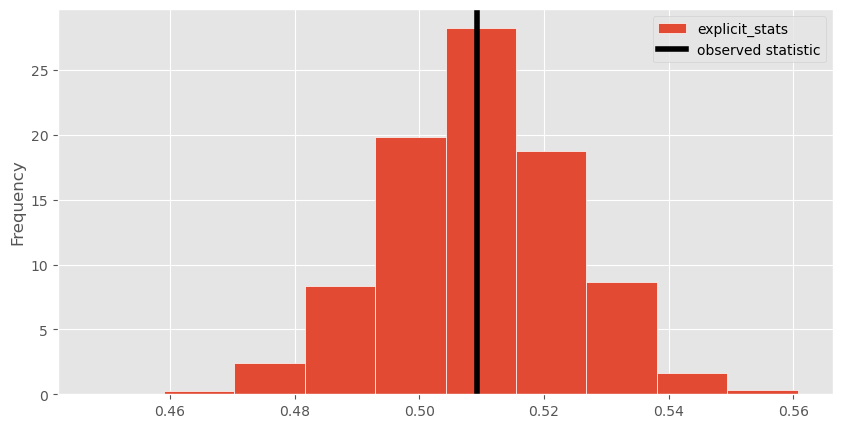

In [11]:
explicit_stats = np.array([])
for i in range(10000):
    sample = unique_exp_counts.sample(unique_exp_counts.shape[0], replace=True)
    sample = sample.groupby('explicit').count()
    sample = sample.assign(Count = sample.get('rank')).get(['Count'])
    stat = sample['Count'].iloc[0]/unique_exp_counts.shape[0]
    explicit_stats = np.append(explicit_stats, stat)
    
# Visualize with a histogram
pd.DataFrame().assign(explicit_stats=explicit_stats).plot(kind='hist', \
    density=True, ec='w', figsize=(10, 5));
plt.axvline(x=observed_nonexp_prop, color='black', linewidth=4, \
    label='observed statistic')
plt.legend();

In [12]:
explicit_p_value =  np.count_nonzero(explicit_stats >= observed_nonexp_prop) / len(explicit_stats)
explicit_p_value

0.5149

Since the p-value yields a value greater than the standard of 0.05 for a statistically significant result, we fail to reject the null hypothesis. This means that it is likely that any difference between the number of explicit and nonexplicit songs is due to random chance and explicitness is not very influential in determining whether a song reaches the top 200 on Spotify Charts.

Let's also compare the rank between explicit and nonexplicit songs.

-0.9138036570628714

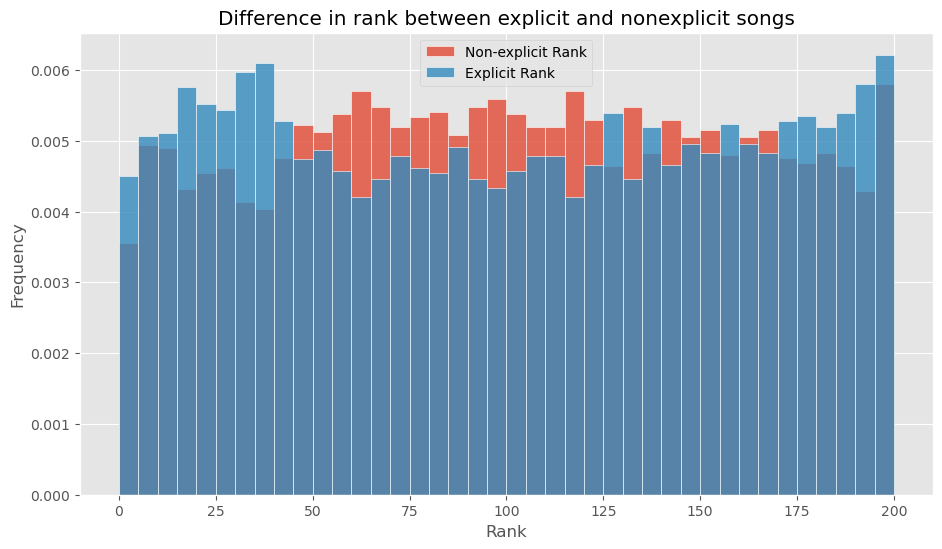

In [13]:
non_exp_rank = charts_info[charts_info['explicit'] == False]['rank']
exp_rank = charts_info[charts_info['explicit'] == True]['rank']
rank_difference = exp_rank.mean() - non_exp_rank.mean()

fig, ax = plt.subplots()
baby_bins = np.arange(0, 201, 5)
non_exp_rank_df = pd.DataFrame().assign(
    non_exp_rank=non_exp_rank)
exp_rank_df = pd.DataFrame().assign(
    exp_rank=exp_rank)
non_exp_rank_df.plot(kind='hist', density=True, ax=ax, ec='w',bins=baby_bins, \
    alpha=0.8, figsize=(11, 6));
exp_rank_df.plot(kind='hist', density=True, ax=ax, ec='w',bins=baby_bins, \
    alpha=0.8, figsize=(11, 6));
plt.legend(['Non-explicit Rank', 'Explicit Rank'])
plt.xlabel('Rank');
plt.title('Difference in rank between explicit and nonexplicit songs');

rank_difference

This visualization is interesting because it looks like that there are more songs in the top 50 that are explicit, but there are less songs in the top 50-150 that are explicit. There could be many reasons why this is the case. For example, maybe popular genres or artists streamed on Spotify are more likely to have songs with explicit content. Or it could even be that the lyrical themes or audio features of an explicit song make a song more popular in the music landscape and which gets the song more streams. However, `rank_difference` tells us there is a very small difference in rank between the means of both categories, so it is possible this is all due to random chance. We also already know from our hypothesis test that there are roughly the same amount of nonexplicit and explicit songs in the top 200. Let's perform a permutation test to see if the reesult matches our expectations.

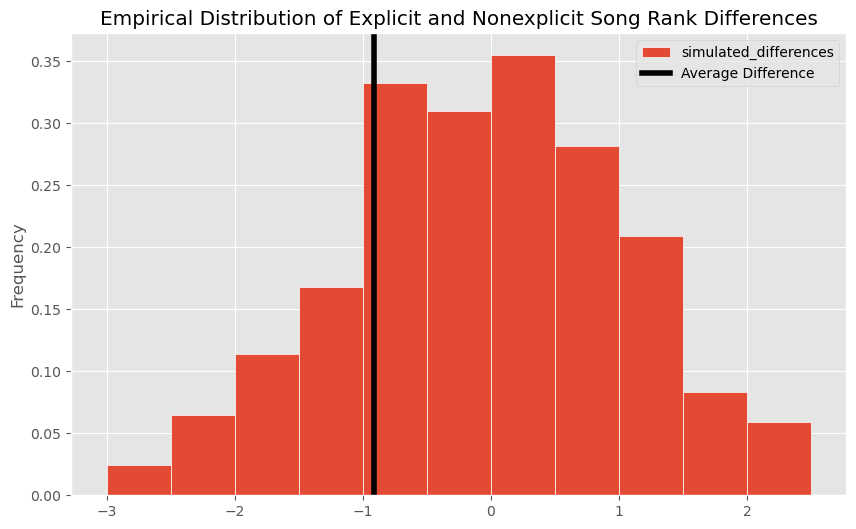

In [14]:
rank_vs_explicit = charts_info.get(['rank', 'explicit'])
simulated_differences = np.array([])

for i in range(1000):
    rank_vs_explicit_shuffled = rank_vs_explicit.assign(shuffled_ranks = \
        np.random.permutation(rank_vs_explicit['rank']))
    nonexplicit_ranks = rank_vs_explicit_shuffled[rank_vs_explicit_shuffled \
        ['explicit'] == False].get('shuffled_ranks')
    explicit_ranks = rank_vs_explicit_shuffled[rank_vs_explicit_shuffled \
        ['explicit'] == True].get('shuffled_ranks')
    difference = explicit_ranks.mean() - nonexplicit_ranks.mean()
    simulated_differences = np.append(simulated_differences, difference)
    
(pd.DataFrame().assign(simulated_differences=simulated_differences)
    .plot(kind='hist', bins = np.arange(-3, 3, 0.5), 
    density=True, ec='w', figsize=(10, 6),
    title='Empirical Distribution of Explicit and Nonexplicit Song Rank Differences'));
plt.axvline(rank_difference, color='black', linewidth=4, label='Average Difference')
plt.legend();


The code above shrinks the `charts_info` dataframe and only keeps the `rank` and `explicit` columns. It then shuffles the True/False `explicit` labels for each rank, so we can determine if explicit and nonexplicit songs come from the same distribution. 

In [15]:
p_value = np.count_nonzero(simulated_differences >= rank_difference) / len(simulated_differences)
p_value

0.789

Our computed p-value for this permutation test is also a value much greater than the cutoff of 0.05 for a statistically significant result, so we fail to reject the null hypothesis. It appears there is not a very significant difference between the rank of explicit and nonexplicit songs. This makes intuitive sense because Spotify has a large population of users and whether a song is explicit likely doesn't affect how many times a song is streamed, but rather other components to the song such as audio features, lyrics, themes, etc. In fact, there may even be a positive correlation between explicitness and rank for some of the highest ranking songs, as our histogram showed.

## Exploring Genres

One variable of interest that cannot be accessed directly through the track data we collected is genre. Since the Spotify Web API does not have genre as a feature of a track, one way we can access a genre data point is through getting the list of genres for the main artist of each track. The `genres` variable of an artist contains a list of genres that they are known for, so this method isn't the most accurate for classifying the genre of a specific track as an artist can perform a wide range of genres that may not be representative of the track. A more strategic approach may involve incorporating all the participating artists of a given track instead of just the main artist, or even looking to outside sources such as last.fm to determine what genre a song is. However, the following method is a simple way to gather some insight into which genres appear the most on the Top 200 by just sticking to the data accessible through the Spotify Web API and the `spotipy` library.

To gather detailed data on an artist, the `spotipy` library has a similar method to the `tracks()` method used to gather track info. However, first we must attain the Spotify URI for each main artist that appears in our `charts_info` dataframe. We can use the list of tracks that we stored earlier and extract the artist info for the main artist of each track, and then get the URI for each of these main artists.

In [16]:
artist_info = [track['artists'][0] for track in track_list]
artist_uris = [artist['uri'] for artist in artist_info]

The `spotipy` `artists()` method also has a limit of 50 URIs that can be taken at a time, so the following code is repurposed to instead take in the `artist_uris` list that we just created.

In [17]:
start = 0
end = 50
step_size = 50
artist_list = []

# Get artist info from the Spotify API 50 URIs at a time 
while end <= charts.shape[0]:
    uri_list = artist_uris[start:end]
    artist_list.append(sp.artists(uri_list))
    start = end
    end += step_size

Once we have a list that contains lists of artist info, we can consolidate this into a new list that stores all the dictionaries of the artist info.

In [18]:
new_artist_info = []

# Put all artist info (dictionaries) into a single list
for dct in artist_list:
    for key, val in dct.items():
        for artist in val:
            new_artist_info.append(artist)

The genres list can then be extracted from each artist dictionary.

In [19]:
genres = [artist['genres'] for artist in new_artist_info]

A genres column can be added to our `charts_info` dataframe, which we will use in some functions to visualize the popularity of genres.

In [20]:
# Create a new column for genres value
charts_info = charts_info.assign(genres = genres)
charts_info

,rank,uri,artist_names,track_name,peak_rank,previous_rank,weeks_on_chart,streams,week,explicit,genres
0,1,spotify:track:7K3BhSpAxZBznislvUMVtn,Morgan Wallen,Last Night,1,1,21,10241241,2023-06-22,True,[contemporary country]
1,2,spotify:track:3qQbCzHBycnDpGskqOWY0E,"Eslabon Armado, Peso Pluma",Ella Baila Sola,1,2,14,9427182,2023-06-22,False,"[corrido, corridos tumbados, sad sierreno, sie..."
2,3,spotify:track:1BxfuPKGuaTgP7aM0Bbdwr,Taylor Swift,Cruel Summer,3,13,32,6268357,2023-06-22,False,[pop]
3,4,spotify:track:1Lo0QY9cvc8sUB2vnIOxDT,Luke Combs,Fast Car,4,5,13,6152329,2023-06-22,False,"[contemporary country, country]"
4,5,spotify:track:7KA4W4McWYRpgf0fWsJZWB,"Tyler, The Creator, Kali Uchis",See You Again (feat. Kali Uchis),5,7,103,5898838,2023-06-22,True,"[hip hop, rap]"
...,...,...,...,...,...,...,...,...,...,...,...
10395,196,spotify:track:58ge6dfP91o9oXMzq3XkIS,Arctic Monkeys,505,18,192,178,2575446,2024-06-13,False,"[garage rock, modern rock, permanent wave, roc..."
10396,197,spotify:track:2ZWlPOoWh0626oTaHrnl2a,Frank Ocean,Ivy,169,183,9,2574631,2024-06-13,True,"[lgbtq+ hip hop, neo soul]"
10397,198,spotify:track:53IRnAWx13PYmoVYtemUBS,Chappell Roan,Femininomenon,198,-1,1,2572362,2024-06-13,True,"[indie pop, pov: indie]"
10398,199,spotify:track:4obHzpwGrjoTuZh2DItEMZ,Morgan Wallen,7 Summers,3,-1,68,2571426,2024-06-13,False,[contemporary country]


The function defined below aims to count the number of songs in each genre that appears in a Series of genres (a column of a dataframe, like the genres column in `charts_info`). 

In [21]:
def genre_count(genres, threshold):
    genre_count = {}
    for genre_list in genres:
        for genre in genre_list:
            if genre not in genre_count:
                genre_count[genre] = 1
            else:
                genre_count[genre] += 1
    genre_count_threshold = {}
    for key, val in genre_count.items():
        if val >= threshold:
            genre_count_threshold[key] = val
    genre_count_threshold = dict(reversed(sorted(genre_count_threshold.items(), \
        key=lambda item: item[1])))     
    genre_df = pd.DataFrame(list(genre_count_threshold.items()), \
        columns=['Genre', 'Count']).sort_values(by='Count').set_index('Genre')
    genre_df.plot(kind='barh', y='Count', \
        title='Genres ranked by number of occurences in Spotify Top 200', figsize=(9, 9));   

The second parameter of `genre_count` is the threshold that will be considered for the histogram produced. The ability to change this threshold is useful when analyzing the top occurring genres. We found that 450 occurrences encompassed most of the main genres we are interested in while skipping the subgenres that are overlapped by one of the main genres (e.g. 'atl hip hop' had over 400 occurrences but is a subgenre of 'hip hop'). Note that we are using `charts_info['genres']` here which contains song data for 52 weeks, including all repeat occurrences of songs that have charted throughout the timeframe.

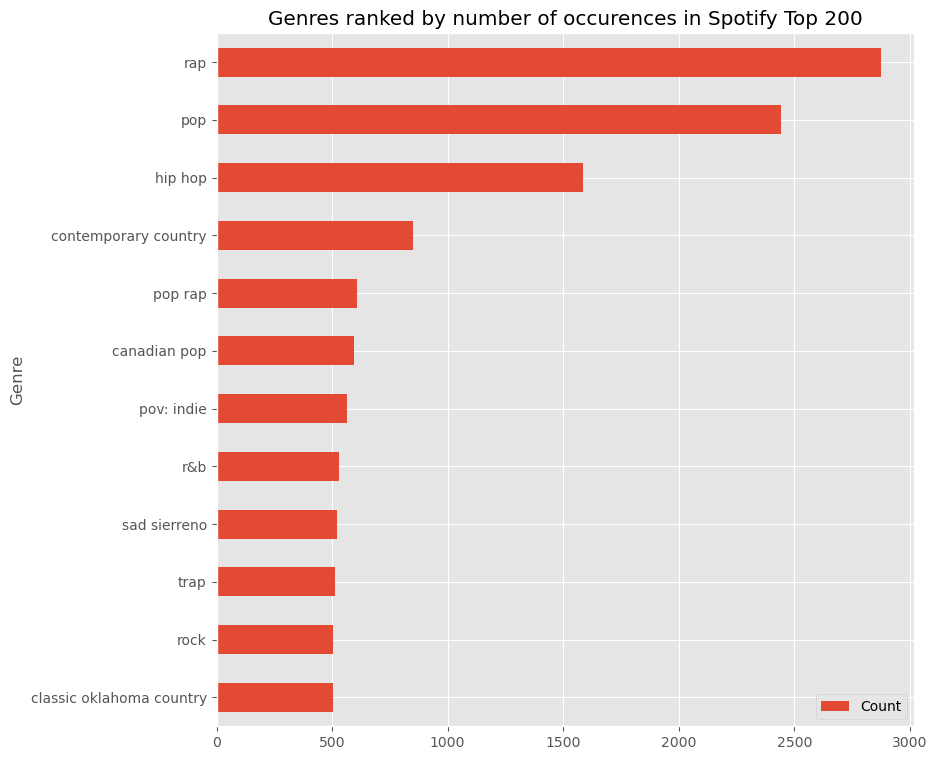

In [22]:
genre_count(charts_info['genres'], 450)

It's clear that 'rap' and 'pop' are two dominant genres in our dataset. Given what we've learned about the popularity of these genres, let's figure out how many explicit songs each genre produces.

In [23]:
def calculate_genre_explicit(explicit_list, genre_list, count_threshold):
    genre_explicit = {}
    genre_count = {}
    genre_explicit_props = {}
    for i, j in zip(explicit_list, genre_list):
        for genre in j:
            if i == True:
                if genre not in genre_explicit:
                    genre_explicit[genre] = 1
                else:
                    genre_explicit[genre] += 1
            if genre not in genre_count:
                genre_count[genre] = 1
            else:
                genre_count[genre] += 1
    for genre in genre_explicit:
        if genre_count[genre] >= count_threshold:
            genre_explicit_props[genre] = genre_explicit[genre] / genre_count[genre]
    genre_explicit_props = dict(reversed(sorted(genre_explicit_props.items(), \
        key=lambda item: item[1])))     
    genre_df = pd.DataFrame(list(genre_explicit_props.items()), \
        columns=['Genre', 'Proportion']).sort_values(by='Proportion').set_index('Genre')
    genre_df.plot(kind='barh', y='Proportion', \
        title='Genres ranked by proportion of explicit songs', figsize=(9, 9));   

This function builds on `genre_count()` by calculating how many explicit songs of each genre there are, and finding the proportion of explicit songs relative to the total number of songs of a given genre. It also has a parameter `count_threshold`, which is used to filter out genres that do not appear at least `count_threshold` number of times. When we call `calculate_genre_explicit` below, setting this argument helps us see which genres are the most popular.

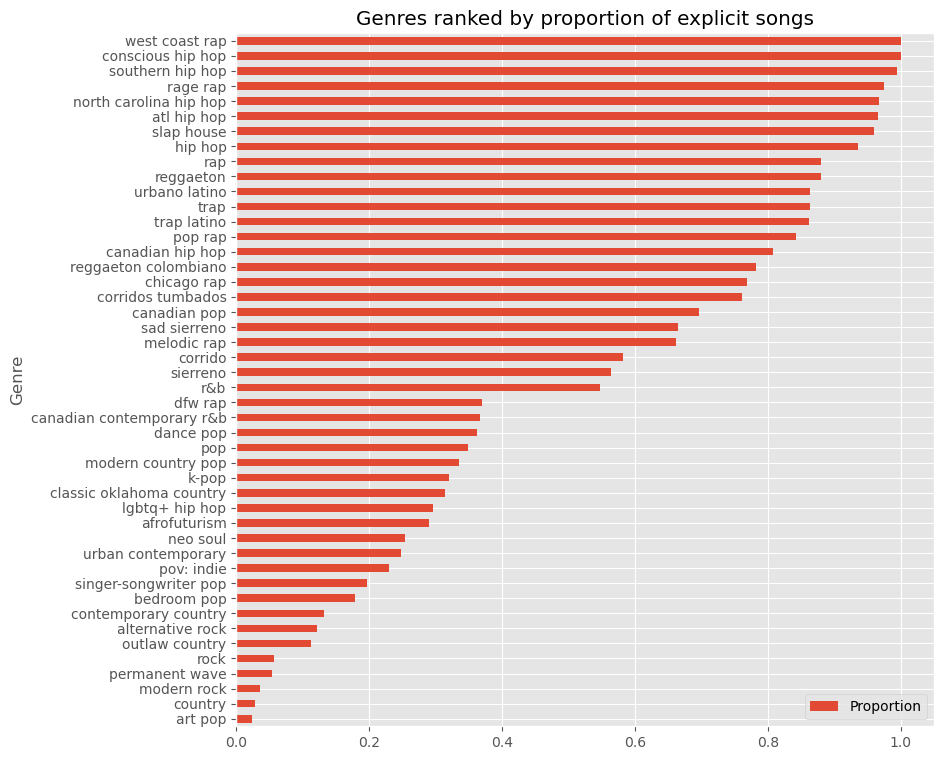

In [24]:
calculate_genre_explicit(charts_info['explicit'], charts_info['genres'], 100)

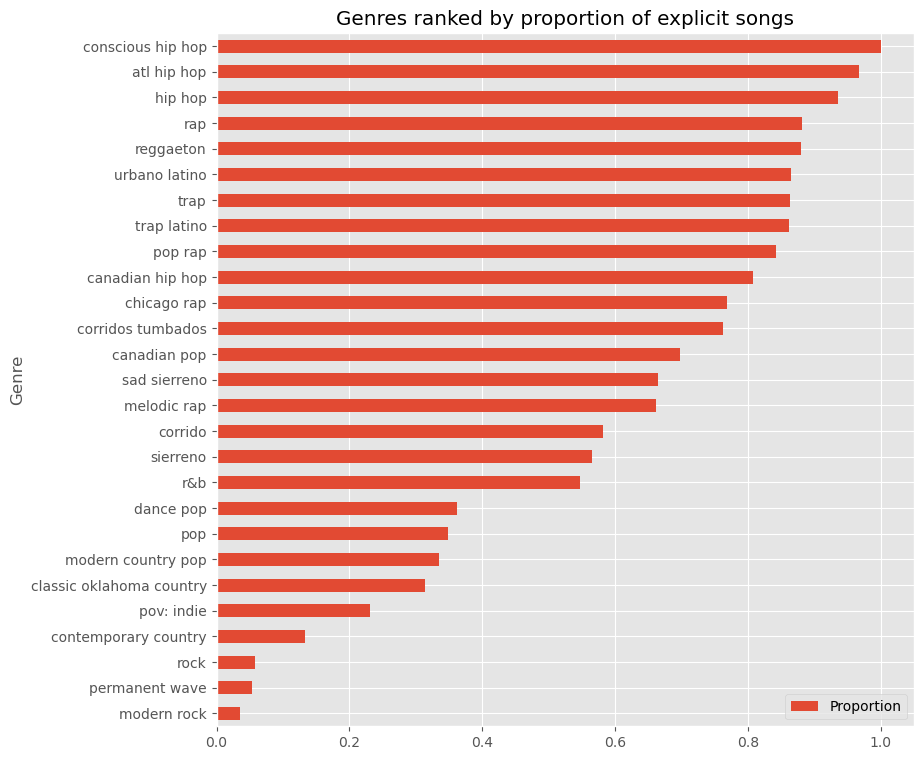

In [25]:
calculate_genre_explicit(charts_info['explicit'], charts_info['genres'], 250)

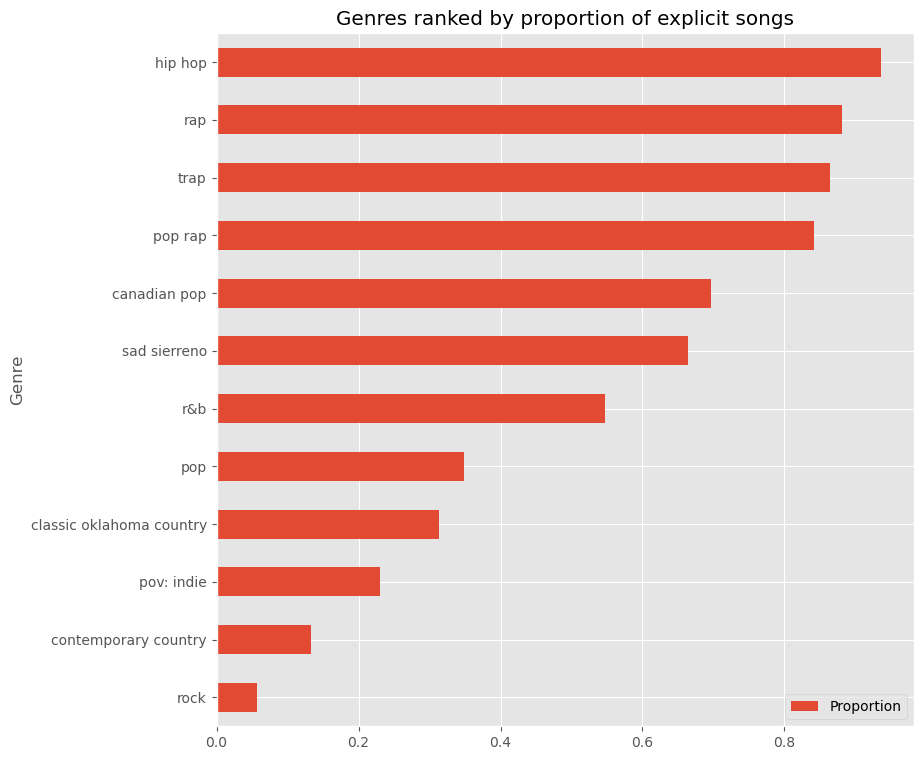

In [26]:
calculate_genre_explicit(charts_info['explicit'], charts_info['genres'], 500)

Among genres with at least 500 occurences, it appears that songs from artists in 'hip hop', 'rap', 'trap', and 'pop rap' have the most explicit songs, with over 80% percent being explicit. It's notable to recall that 'pop' had the second most occurrences in the Top 200, but less than 40% of those songs are explicit. Meanwhile, 'contemporary country', the fourth highest occurring genre in the Top 200, has less than 20% of its songs that are explicit.

Although we had to classify the genres of each song here using the main artist of the track, we can still take away some interesting findings. Thanks to the Python `spotipy` library and the Spotify Web API, there remains a lot to be explored about Spotify music data!